In [2]:
import os
import json
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [6]:
with open('datasets/prewar.txt', 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 10000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(['i have done with this mighty argument , of self - government .',
       'the need of capital which american farmers feel to - day had been experienced by the farmers of europe , with their centuries - old farms , many years ago .',
       'the use of a navy is for military purposes , and there has been found need in the department of a military branch dealing directly with the military use of the fleet .',
       'they are not temptation to war , but security against it .',
       'in recommending this program i am thinking not only of the immediate economic needs of the people of the nation , but also of their personal liberties --the most precious possession of all americans .'],
      dtype='<U4674')

### Generating text sequences with labels (word index)

In [7]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [8]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [9]:
SEQ_LEN = 500

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    labels = np.array(list(map(lambda x: x[2], info)))
    return tokens, labels

tokens, labels = generate_seq()
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56]),
 array([50, 17, 16, 16, 16, 17, 17, 16, 15, 15, 14, 17, 14, 12, 12, 11, 11,
        11, 12, 11, 11, 11, 10, 10,  8,  9,  7,  8,  7,  6,  6,  7,  6,  4,
         4,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,
         3,  2,  3,  2,  1,  1,  1]))

### Generate Embeddings

In [10]:
N_SEQS = 1000
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 10

torch.set_grad_enabled(False)

all_resids = []
all_labels = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, labels = generate_seq()

    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    labels = labels[PREFIX_CUTOFF:]

    assert residuals.shape[1] == labels.shape[0]

    # this mask excludes puncuation and word fragments
    mask = labels != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_labels.append(labels[mask])



100%|██████████| 1000/1000 [07:46<00:00,  2.14it/s]


In [14]:
x_all_layers = np.concatenate(all_resids, axis=1)
y_all = np.concatenate(all_labels)

print(x_all_layers.shape)
print(y_all.shape)

(12, 460969, 768)
(460969,)


### filter data

In [23]:
LAYER = 2

# only look at labels for words 0-9
mask = y_all <= 9

X = x_all_layers[LAYER, mask]
Y = y_all[mask]

print(X.shape)
print(Y.shape)

(134689, 768)
(134689,)


## Training Probes

In [24]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [25]:
probing_dataset = ProbingDataset(X, Y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 134689 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([14437, 13782, 13458, 13467, 13367, 13280, 13107, 13153, 13251,
       13387]))
split into [test/train], [26938/107751]


In [26]:
probe = LinearProbe(device, 768, 10)

EXPERIMENT_NAME = "prewar_words10_133k"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
config = TrainerConfig(num_epochs=40, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [27]:
trainer.train()

Epoch 40; Train Loss: 1.11882; Train Acc: 55.602%; Test Acc: 54.310%: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it]


In [28]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9915    0.9849    0.9882      2847
           1     0.9179    0.9312    0.9245      2763
           2     0.7827    0.7736    0.7781      2761
           3     0.5797    0.5944    0.5870      2697
           4     0.4363    0.3578    0.3932      2672
           5     0.3319    0.4444    0.3800      2644
           6     0.2997    0.2025    0.2417      2672
           7     0.3095    0.1998    0.2428      2603
           8     0.3021    0.3835    0.3380      2657
           9     0.4042    0.4969    0.4458      2622

    accuracy                         0.5431     26938
   macro avg     0.5356    0.5369    0.5319     26938
weighted avg     0.5418    0.5431    0.5382     26938



### plotting loss curves

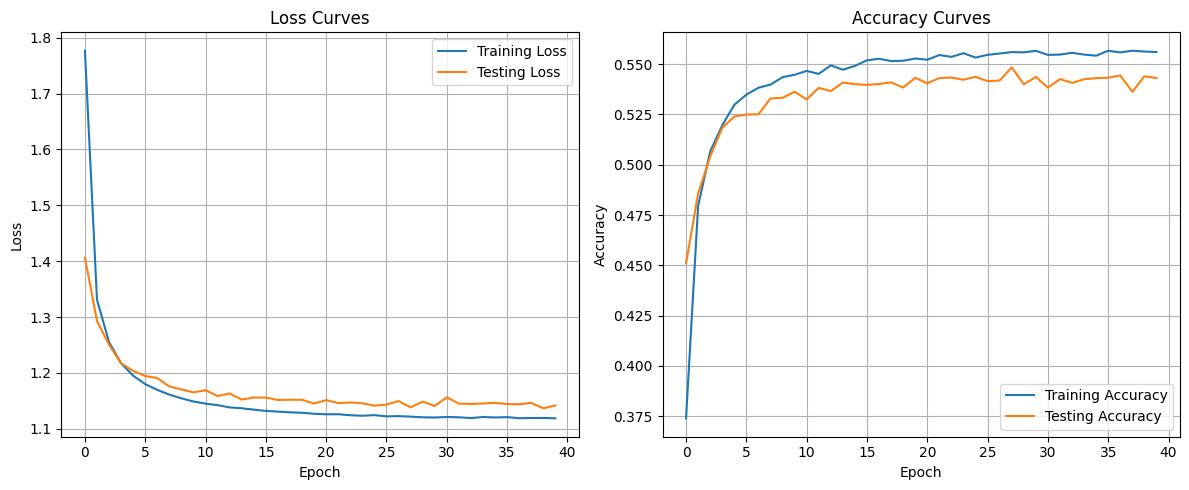

In [29]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()